# GLM with small dataset
idea:

use generalized linear model to predict gap days as a function of drug, using total drug duration as an offset \
drug: factor with 16 levels

In [1]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import glm
import statsmodels.api as sm

In [2]:
df = pd.read_csv("../../dataset/small_focused_df.csv")
df = df.drop(columns=["eid"])
df.head()

,drug_concept_id,drug_era_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,concept_name,atc_code
0,708298,1700807090784,12/12/2013,10/01/2014,1,0,midazolam,N05CD08
1,708298,1666447356341,29/04/2013,28/05/2013,1,0,midazolam,N05CD08
2,708298,1194000953715,05/09/2013,26/10/2013,4,0,midazolam,N05CD08
3,708298,1065151983292,16/02/2011,17/03/2011,1,0,midazolam,N05CD08
4,708298,996432425515,14/03/2016,12/04/2016,1,0,midazolam,N05CD08


In [7]:
print(len(df["atc_code"].unique()))
print(len(df))

16
17668


In [4]:
df["drug_era_start_date"] = pd.to_datetime(df["drug_era_start_date"], format="%d/%m/%Y")
df["drug_era_end_date"] = pd.to_datetime(df["drug_era_end_date"], format="%d/%m/%Y")
# duration = drug_era_end_date - drug_era_start_date + 1
df["duration"] = (df["drug_era_end_date"] - df["drug_era_start_date"]).dt.days + 1

In [5]:
df.head()

,drug_concept_id,drug_era_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,concept_name,atc_code,duration
0,708298,1700807090784,2013-12-12,2014-01-10,1,0,midazolam,N05CD08,30
1,708298,1666447356341,2013-04-29,2013-05-28,1,0,midazolam,N05CD08,30
2,708298,1194000953715,2013-09-05,2013-10-26,4,0,midazolam,N05CD08,52
3,708298,1065151983292,2011-02-16,2011-03-17,1,0,midazolam,N05CD08,30
4,708298,996432425515,2016-03-14,2016-04-12,1,0,midazolam,N05CD08,30


In [27]:
# print all the drug_concept_id
print(df["drug_concept_id"].unique())

[  708298   710650   733523   902722   929435   967496   978236  1377141
  1436650  1583722  1742253  1778162 19005147 19095043 19122137 40239216]


In [31]:
# see the summary statistics of duration for drugs
print(df[df["drug_concept_id"] == 733523]["duration"].describe())

count     441.000000
mean      254.829932
std       340.149433
min         5.000000
25%        32.000000
50%       116.000000
75%       312.000000
max      2277.000000
Name: duration, dtype: float64


log(E(gap_days)) = β₀ + β₁X₁ + β₂X₂ + ... + log(duration), which is equivalent to \
E(gap_days) = duration × exp(β₀ + β₁X₁ + β₂X₂ + ...)

log(λᵢ) = β₀ + β₁X₁ᵢ + β₂X₂ᵢ + ... + log(durationᵢ)

Where: \
E(gap_days) is the expected number of gap days \
β₀ is the intercept \
β₁, β₂, ... are coefficients for each drug type \
X₁, X₂, ... are dummy variables (0/1) for drug types

In [62]:
# Fit GLM with Poisson distribution
poisson_model = glm(
    formula="gap_days ~ C(atc_code)",
    data=df,
    family=sm.families.Poisson(link=sm.families.links.Log()),
    offset=np.log(df["duration"]),
)
poisson_results = poisson_model.fit()
# Display summary
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               gap_days   No. Observations:                17668
Model:                            GLM   Df Residuals:                    17652
Model Family:                 Poisson   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2294e+05
Date:                Fri, 22 Nov 2024   Deviance:                   2.2328e+05
Time:                        00:45:38   Pearson chi2:                 2.39e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.8248
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

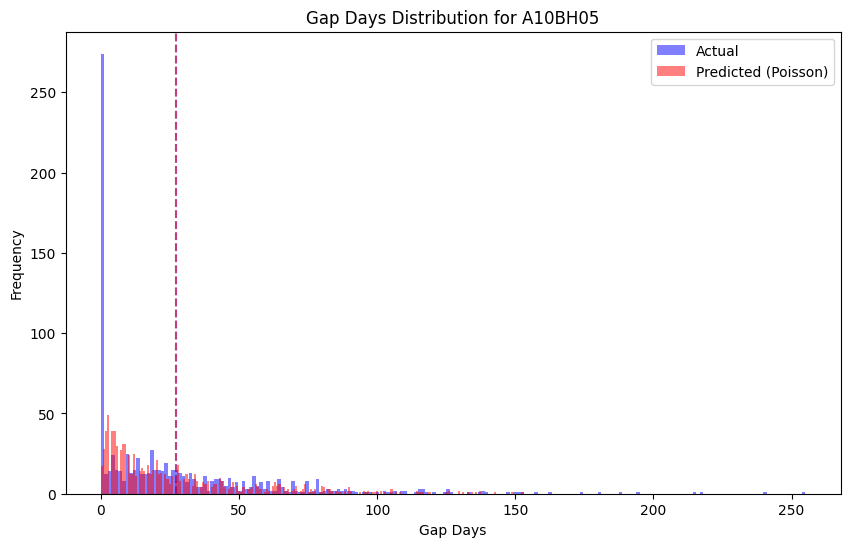

Actual mean: 27.27
Predicted mean: 27.27
Actual variance: 1255.70
Predicted variance: 27.27


In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Filter data for N05CD08
drug_data = df[df["atc_code"] == "A10BH05"].copy()

# Get actual gap days
actual_gap_days = drug_data["gap_days"]

# Calculate predicted gap days (λ)
# Assuming your model results are in 'results'
drug_coef = poisson_results.params[
    poisson_results.params.index == "C(atc_code)[T.A10BH05]"
].values[0]
predicted_means = drug_data["duration"] * np.exp(
    poisson_results.params["Intercept"] + drug_coef
)

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(actual_gap_days, bins=200, alpha=0.5, label="Actual", color="blue")
plt.hist(
    np.random.poisson(predicted_means),
    bins=200,
    alpha=0.5,
    label="Predicted (Poisson)",
    color="red",
)

plt.title("Gap Days Distribution for A10BH05")
plt.xlabel("Gap Days")
plt.ylabel("Frequency")
plt.legend()

# Optional: Add vertical lines for means
plt.axvline(actual_gap_days.mean(), color="blue", linestyle="--", alpha=0.5)
plt.axvline(predicted_means.mean(), color="red", linestyle="--", alpha=0.5)

plt.show()

# Print some summary statistics
print(f"Actual mean: {actual_gap_days.mean():.2f}")
print(f"Predicted mean: {predicted_means.mean():.2f}")
print(f"Actual variance: {actual_gap_days.var():.2f}")
print(
    f"Predicted variance: {predicted_means.mean():.2f}"
)  # For Poisson, mean = variance

In [43]:
# create a new df with gap rate = gap_days / duration
df["gap_rate"] = df["gap_days"] / df["duration"]
df.head()

,drug_concept_id,drug_era_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,concept_name,atc_code,duration,predicted_gap,gap_rate
0,708298,1700807090784,2013-12-12,2014-01-10,1,0,midazolam,N05CD08,30,0.02265,0.0
1,708298,1666447356341,2013-04-29,2013-05-28,1,0,midazolam,N05CD08,30,0.02265,0.0
2,708298,1194000953715,2013-09-05,2013-10-26,4,0,midazolam,N05CD08,52,0.02265,0.0
3,708298,1065151983292,2011-02-16,2011-03-17,1,0,midazolam,N05CD08,30,0.02265,0.0
4,708298,996432425515,2016-03-14,2016-04-12,1,0,midazolam,N05CD08,30,0.02265,0.0


In [63]:
# Fit GLM with Negative Binomial distribution
nb_model = glm(
    formula="gap_days ~ C(atc_code)",
    data=df,
    family=sm.families.NegativeBinomial(alpha=1.0),
    offset=np.log(df["duration"]),
)
nb_results = nb_model.fit()
print(nb_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               gap_days   No. Observations:                17668
Model:                            GLM   Df Residuals:                    17652
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35304.
Date:                Fri, 22 Nov 2024   Deviance:                       32591.
Time:                        00:46:58   Pearson chi2:                 4.94e+04
No. Iterations:                    12   Pseudo R-squ. (CS):             0.2433
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Model Comparison:
Poisson AIC: 245918.62757559735
Negative Binomial AIC: 70640.4274670641

Estimated alpha: 1.0

Diagnostics:
Log-likelihood: -35304.21373353205
Deviance: 32590.950900319076
Pearson Chi-squared: 49433.33060094344
Df Residuals: 17652

Dispersion (Pearson Chi2/df): 2.80


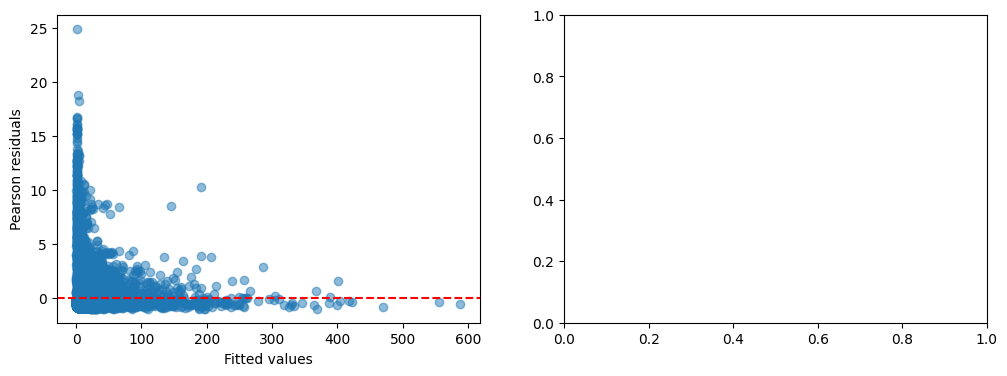

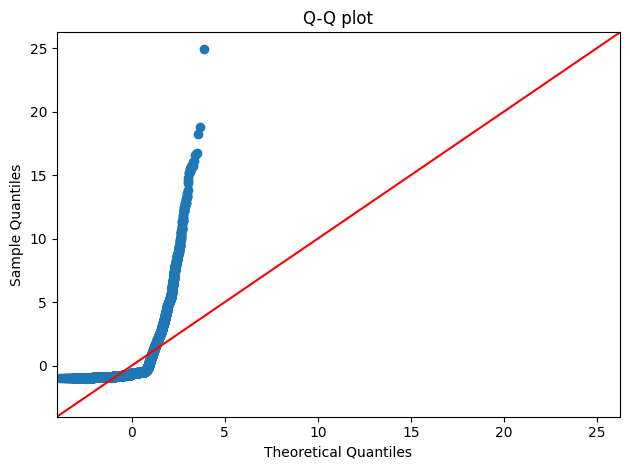

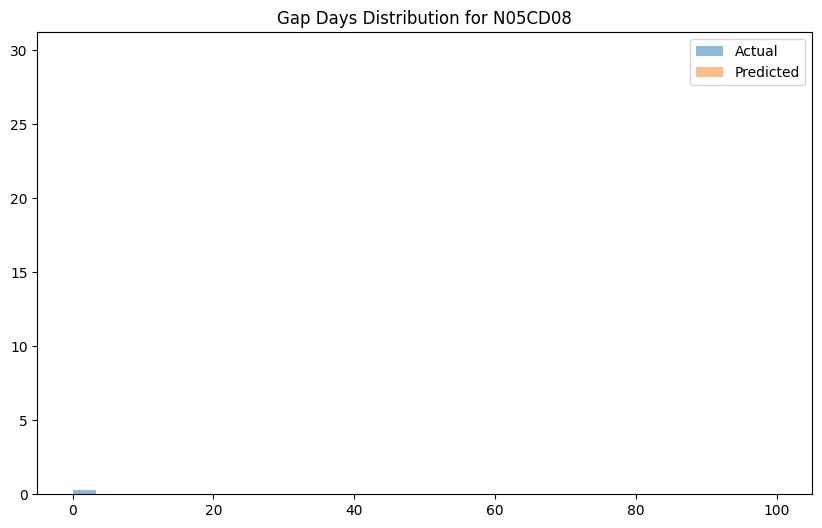

In [64]:
from statsmodels.graphics.gofplots import ProbPlot

# Print comparison
print("Model Comparison:")
print(f"Poisson AIC: {poisson_results.aic}")
print(f"Negative Binomial AIC: {nb_results.aic}")
print(f"\nEstimated alpha: {nb_results.scale}")

# Basic diagnostics
print("\nDiagnostics:")
print(f"Log-likelihood: {nb_results.llf}")
print(f"Deviance: {nb_results.deviance}")
print(f"Pearson Chi-squared: {nb_results.pearson_chi2}")
print(f"Df Residuals: {nb_results.df_resid}")

# Calculate and print dispersion (should be closer to 1 than Poisson)
dispersion = nb_results.pearson_chi2 / nb_results.df_resid
print(f"\nDispersion (Pearson Chi2/df): {dispersion:.2f}")

# Plot diagnostics
residuals = nb_results.resid_pearson
fitted = nb_results.fittedvalues

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Pearson residuals")

plt.subplot(122)
ProbPlot(residuals).qqplot(line="45")
plt.title("Q-Q plot")
plt.tight_layout()
plt.show()

# Look at one drug's distribution
drug = df["atc_code"].unique()[0]  # first drug
drug_data = df[df["atc_code"] == drug]

plt.figure(figsize=(10, 6))
plt.hist(drug_data["gap_days"], bins=30, alpha=0.5, label="Actual", density=True)
predicted_means = nb_results.predict(drug_data)
plt.hist(
    np.random.negative_binomial(
        n=1, p=1 / (1 + predicted_means), size=len(predicted_means)
    ),
    bins=30,
    alpha=0.5,
    label="Predicted",
    density=True,
)
plt.legend()
plt.title(f"Gap Days Distribution for {drug}")
plt.show()